In [1]:
import networkx as nx
import pandas as pd
import tarfile
import requests
from io import BytesIO

def load_librec_filmtrust_trust():
    url = 'http://konect.cc/files/download.tsv.librec-filmtrust-trust.tar.bz2'
    extract_filename = 'librec-filmtrust-trust/out.librec-filmtrust-trust'
    response = requests.get(url)
    tar_file = BytesIO(response.content)

    with tarfile.open(fileobj=tar_file, mode="r:bz2") as tar:
        extracted_file = tar.extractfile(extract_filename)
        df = pd.read_csv(extracted_file, comment='%', delimiter='\t', header=None, names=['src', 'dst'])

    G = nx.from_pandas_edgelist(df, 'src', 'dst', create_using=nx.DiGraph())
    return G

G = load_librec_filmtrust_trust()
print(G)

DiGraph with 874 nodes and 1853 edges


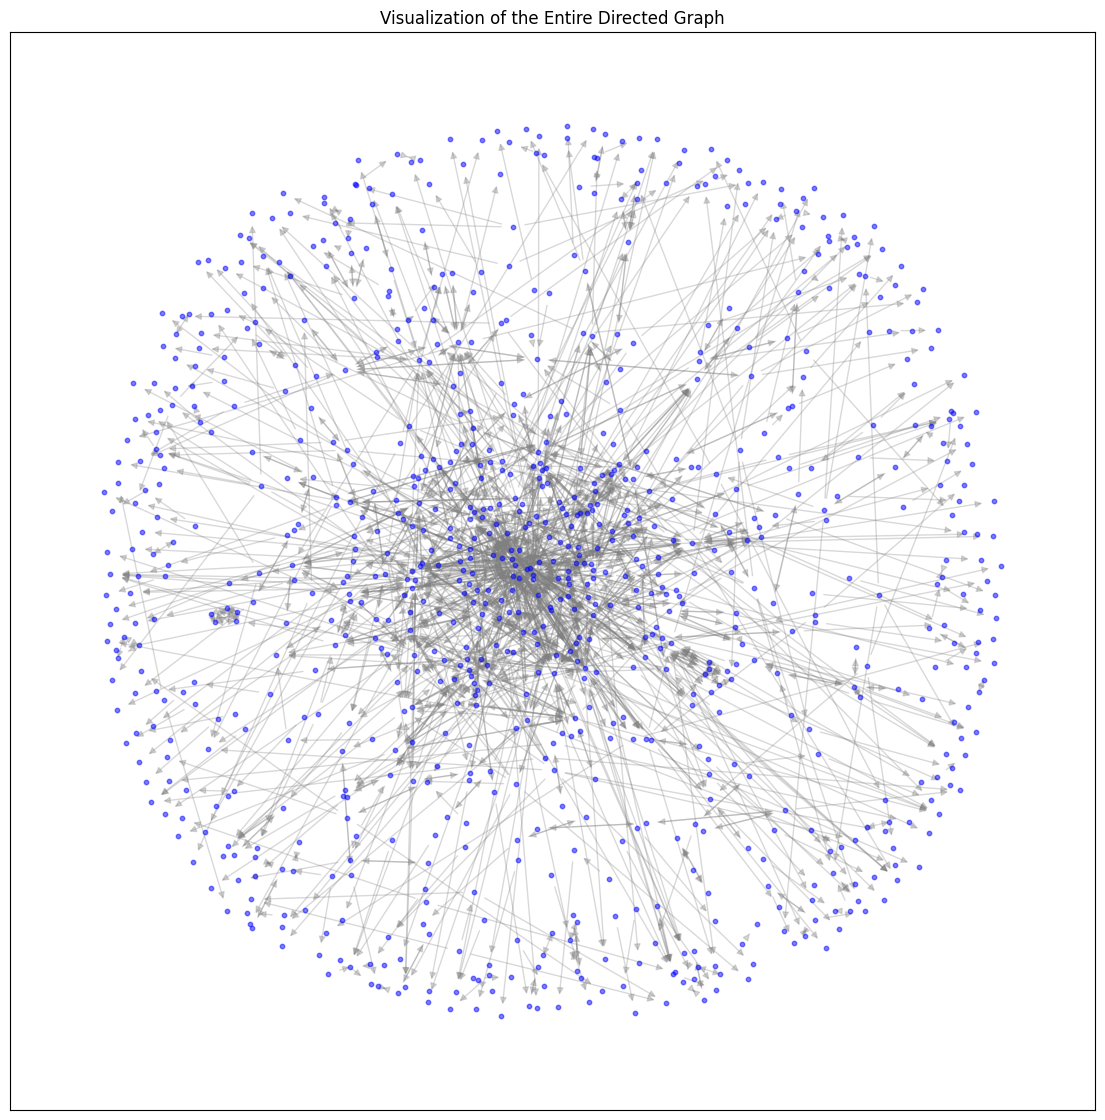

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Function to draw the entire graph
def draw_entire_graph(G, node_size=10, node_color='blue', node_alpha=0.5, edge_color='gray', edge_alpha=0.3):
    plt.figure(figsize=(14, 14))  # Increase the figure size for better visibility
    pos = nx.spring_layout(G, k=0.1)  # k controls the distance between nodes
    nx.draw_networkx_nodes(G, pos, node_size=node_size, node_color=node_color, alpha=node_alpha)
    nx.draw_networkx_edges(G, pos, arrowstyle='-|>', arrowsize=10, edge_color=edge_color, alpha=edge_alpha)
    plt.title("Visualization of the Entire Directed Graph")
    plt.show()

# Draw the entire graph
draw_entire_graph(G)


In [3]:
from scipy.sparse.linalg import eigs
import numpy as np

from randcolorgraphs.utils.calculate_katz import calculate_katz

def get_adj_and_katz(G, alpha=0.1, beta=1.0):
    A_G = nx.adjacency_matrix(G).astype(np.float64)

    eigenvalues, _ = eigs(A_G, k=1, which='LM')  # 'LM': Largest Magnitude, tol is tolerance
    spectral_radius_G = np.abs(eigenvalues).max()
    print(f"Spectral Radius: {spectral_radius_G}, alpha_max = {1/spectral_radius_G}")
    print("calculating katz centrality")
    katz_centrality = calculate_katz(A_G, alpha = alpha, beta=beta)
    print("done calculating katz")

    # Reorder nodes based on Katz centrality
    sorted_indices = np.argsort(katz_centrality)
    sorted_nodes = np.array(G.nodes())[sorted_indices]

    # Generate the adjacency matrix
    adj_matrix = nx.adjacency_matrix(G, nodelist=sorted_nodes)

    sorted_katz_vector = katz_centrality[sorted_indices]

    assert np.allclose(sorted_katz_vector, calculate_katz(adj_matrix.astype(np.float64), alpha = alpha, beta=beta))
    return adj_matrix, sorted_katz_vector

In [4]:
A_G, katz_centrality = get_adj_and_katz(G, alpha = 0.06)
A_G_dense = A_G.todense()

Spectral Radius: 11.66806170409366, alpha_max = 0.08570403768512441
calculating katz centrality
Katz converged after 84 iterations.
done calculating katz
Katz converged after 84 iterations.


In [11]:
import kmeans1d

from randcolorgraphs.objectives.get_cluster_loss_ell_sqr import get_cluster_loss_ell_sqr
from randcolorgraphs.objectives.get_expected_edgeoverlap import get_expected_edgeoverlap
from randcolorgraphs.algorithms.linear_scalarization.optimal_contiguous.optimal_contiguous_linear_scalarization_algo import optimal_contiguous_linear_scalarization_algo


from fast_pareto import is_pareto_front

def evaluate_cluster_assignment(katz_centrality, A, clusters):
    ell_sqr = get_cluster_loss_ell_sqr(katz_centrality, clusters)
    expected_edge_overlap = get_expected_edgeoverlap(A, clusters)
    return [ell_sqr, expected_edge_overlap]

### Analyze all possible clusters for their performance regarding specific merics and booleans
df = pd.DataFrame(columns=["ell_sqr", "expected_edge_overlap", "method_type"])

max_k = 30
for k in range(1, 300, 2):
    colors, _ = kmeans1d.cluster(katz_centrality, k)
    clusters = np.array(colors)
    df.loc[len(df)] = evaluate_cluster_assignment(katz_centrality, A_G, clusters) + [f"Kmeans1d (k={k}) on Katz centrality"]

In [12]:
for w in np.exp(-np.linspace(0,18,30)):
    clusters = optimal_contiguous_linear_scalarization_algo(katz_centrality, A_G_dense, w)
    print(f"Done w={w}")
    df.loc[len(df)] = evaluate_cluster_assignment(katz_centrality, A_G, clusters) + [f"Opt. Cont. Scal. (w={w})"]


Done w=1.0
Done w=0.5375735693311237
Done w=0.28898534244340446
Done w=0.155350882021678
Done w=0.08351252814713174
Done w=0.04489412783991955
Done w=0.024133896544913314
Done w=0.012973744907517126
Done w=0.006974342357525472
Done w=0.0037492221148722124
Done w=0.0020154827145070398
Done w=0.0010834702367627316
Done w=0.0005824449624405788
Done w=0.0003131070173981146
Done w=0.00016831805692532658
Done w=9.048333864422716e-05
Done w=4.864145131997396e-05
Done w=2.6148358603524477e-05
Done w=1.4056666466646865e-05
Done w=7.556492365372464e-06
Done w=4.0621705724766655e-06
Done w=2.1837155338781333e-06
Done w=1.1739077539506896e-06
Done w=6.310617813567543e-07
Done w=3.392421342724073e-07
Done w=1.8236760498832651e-07
Done w=9.803600434394323e-08
Done w=5.2701564778134974e-08
Done w=2.8330968287117475e-08
Done w=1.522997974471263e-08


In [7]:
from randcolorgraphs.algorithms.linear_scalarization.unoptimized_greedy_search import unoptimized_greedy_search_linear_scalarization


#for w in [0.01]: #np.exp(-np.linspace(0,15,30)):
#    init_clusters = np.array([0]*len(katz_centrality), dtype=np.int64)
#    clusters, _ = unoptimized_greedy_search_linear_scalarization(katz_centrality, A_G_dense, init_clusters, w=w, pam_cluster_dist=2)
#    print(f"Done w={w}")
#    df.loc[len(df)] = evaluate_cluster_assignment(katz_centrality, A_G, clusters) + [f"Greedy Search (w={w})"]
#

Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: swap
Optimal move in this round: merge-split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: merge-split
Optimal move in this round: split
Optimal move in this round: split
Optimal move in this round: merge-split
Optimal move in this round: merge-split
Optimal move in this round: split
Optimal move in this round: swap
Optimal move in this round

In [13]:
df["is_pareto_front"] = is_pareto_front(df[['ell_sqr', 'expected_edge_overlap']].values)

In [14]:
import pandas as pd
import plotly.express as px

def get_method_type_name(method_type):
    if 'Kmeans' in method_type:
        return 'Kmeans'
    elif 'Greedy Search' in method_type:
        return 'Greedy Search'
    elif 'Opt. Cont. Scal.' in method_type:
        return 'Opt. Cont. Scal.'
    else:
        return 'Other'

df['method_type_name'] = df['method_type'].apply(get_method_type_name)

# Determining shape based on is_pareto_front
df['shape'] = df['is_pareto_front'].apply(lambda x: 'circle-open' if x else 'square-open')

# Plotting with Plotly
fig = px.scatter(
    df,
    x='ell_sqr',
    y='expected_edge_overlap',
    hover_data=['method_type'],
    symbol='shape',
    color='method_type_name',
    symbol_sequence=['circle-open', 'square-open']
)

fig.update_xaxes(type='log')
fig.update_traces(marker=dict(size=10, line=dict(width=2)))

# Updating layout for legend
fig.update_layout(
    height=800,
    legend_title_text='Method Type',
    legend=dict(
        title='Method Type',
        itemsizing='constant',
        traceorder='normal',
        font=dict(size=10)
    )
)

fig.show()


In [10]:
unique_clusters, cluster_indices = np.unique(clusters, return_inverse=True)
H = np.identity(len(unique_clusters))[cluster_indices]

HtHinv = np.linalg.inv(H.T @ H)
Ppar = H @ HtHinv @ H.T

edge_probs = A @ Ppar

NameError: name 'A' is not defined